# Import libraries

In [1]:
import pandas as pd
import numpy as np
import nltk

from collections import Counter

from sklearn import clone

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

%matplotlib inline

# Import dataset

In [2]:
brand_id = 14680 # Brand_name = Dove

In [3]:
# Import json files (data and metadata)
import codecs, json

with codecs.open('../../Data/CSE_20180215/' + str(brand_id) + '_data.json', 'r', 'utf-8') as f_data:
    tweets_dict_list = json.load(f_data, encoding='utf-8')
    
with codecs.open('../../Data/CSE_20180215/' + str(brand_id) + '_metadata.json') as f_metadata:
    metadata_dict = json.load(f_metadata, encoding='utf-8')

In [4]:
df_full = pd.DataFrame.from_dict(tweets_dict_list)
df_full.head(3)

,labels,lang,link,model_decision,mturker,text
0,"[1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",it,http://www.mundodecaty.com/2015/06/beauty-corn...,None,1,trattamento completo che consenta risultati mi...
1,"[1, 1, 1, 1, 1, 1, 1, 1]",en,http://mymommataughtme.com/sunday-coupon-previ...,None,1,gummies (9/30)\nClairol $2/1 age defy hair col...
2,"[1, 1, 0, 1, 1, 1]",en,http://www.mybatonrougemommy.com/2015/07/cvs-w...,None,1,Max toothpaste 6 oz $2.99 Limit 2$0.50/1 Colga...


In [5]:
df_full = df_full[['text','lang','model_decision','labels','mturker','link']]
df_full.head(5)

,text,lang,model_decision,labels,mturker,link
0,trattamento completo che consenta risultati mi...,it,None,"[1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",1,http://www.mundodecaty.com/2015/06/beauty-corn...
1,gummies (9/30)\nClairol $2/1 age defy hair col...,en,None,"[1, 1, 1, 1, 1, 1, 1, 1]",1,http://mymommataughtme.com/sunday-coupon-previ...
2,Max toothpaste 6 oz $2.99 Limit 2$0.50/1 Colga...,en,None,"[1, 1, 0, 1, 1, 1]",1,http://www.mybatonrougemommy.com/2015/07/cvs-w...
3,"Cream bath by Dove, especially for the winter ...",en,None,[1],0,https://www.facebook.com/107049086007271/posts...
4,You've NEVER seen Dove Cameron look like this ...,en,None,[0],0,https://www.facebook.com/6338692612/posts/1015...


In [6]:
df_full.shape

(5935, 6)

# WARNING! LABELS ASSUMPTION
Here I convert the labels list in the boolean value corresponding to the majority
(Other option would be to repeat the tweet with different labels each time)

In [7]:
def label_unpacking(df):
    
    new_labels_list = []
    
    list_of_label_lists = df_full.iloc[:,3].values # df.labels.values doesn't work ?!
    
    for label_list in list_of_label_lists:
        labels_counter = Counter(label_list)
        if labels_counter[0]>=labels_counter[1]: # Prefer false negatives to false positives
            new_labels_list.append(False)
        else:
            new_labels_list.append(True)
    
    return np.array(new_labels_list)

In [8]:
df_full['answer'] = label_unpacking(df_full)
df = df_full[['text','lang','model_decision','answer','mturker','link']]
df.head(3)

,text,lang,model_decision,answer,mturker,link
0,trattamento completo che consenta risultati mi...,it,None,False,1,http://www.mundodecaty.com/2015/06/beauty-corn...
1,gummies (9/30)\nClairol $2/1 age defy hair col...,en,None,True,1,http://mymommataughtme.com/sunday-coupon-previ...
2,Max toothpaste 6 oz $2.99 Limit 2$0.50/1 Colga...,en,None,True,1,http://www.mybatonrougemommy.com/2015/07/cvs-w...


In [9]:
df.shape

(5935, 6)

In [10]:
df_no_dup = df.drop_duplicates(keep='first', inplace=False)
df_no_dup.shape

(5935, 6)

In [11]:
print("Dataset has {} duplicated samples".format(df.shape[0] - df_no_dup.shape[0]))

Dataset has 0 duplicated samples


### Keep posts only in English and Italian

In [12]:
train_df = df[(df.lang == 'en') | (df.lang == 'it')]
train_df.head(3)

,text,lang,model_decision,answer,mturker,link
0,trattamento completo che consenta risultati mi...,it,None,False,1,http://www.mundodecaty.com/2015/06/beauty-corn...
1,gummies (9/30)\nClairol $2/1 age defy hair col...,en,None,True,1,http://mymommataughtme.com/sunday-coupon-previ...
2,Max toothpaste 6 oz $2.99 Limit 2$0.50/1 Colga...,en,None,True,1,http://www.mybatonrougemommy.com/2015/07/cvs-w...


In [13]:
train_df.shape

(4525, 6)

# Text preprocessing

In [14]:
# Array with all posts text
corpus = train_df.text.values.copy()

In [15]:
def remove_links(corpus):
    
    import re   
    
    regex = re.compile('http\S+') # Remove everything starting with http until whitespace
    
    new_corpus = []    
    for s in corpus:            
        #First parameter is the replacement, second parameter is the input string
        new_corpus.append(regex.sub(' ', s))    
        
    return np.array(new_corpus)    

In [16]:
def remove_punctuation(corpus):
    
    import re   
    
    regex = re.compile('[!"$%()*+,-./:;<=>?[\\]^_`{|}~]') # Keep # & @ 
    
    new_corpus = []    
    for s in corpus:            
        #First parameter is the replacement, second parameter is the input string
        new_corpus.append(regex.sub('', s))    
        
    return np.array(new_corpus)

In [17]:
def remove_numbers(corpus):
    
    import re   
    
    regex = re.compile('[0-9]') # Keep # & @ 
    
    new_corpus = []    
    for s in corpus:            
        #First parameter is the replacement, second parameter is the input string
        new_corpus.append(regex.sub('', s))    
        
    return np.array(new_corpus)

In [18]:
def remove_all_non_alphabetic(corpus):
    
    import re   
    
    regex = re.compile('[^a-zA-Z#@ ]') # Keep whitespaces, hashtags and mentions tags
    
    new_corpus = []    
    for s in corpus:            
        #First parameter is the replacement, second parameter is the input string
        new_corpus.append(regex.sub('', s))    
        
    return np.array(new_corpus)

In [19]:
def encode_hashtags(corpus):
    
    import re
    
    new_corpus = []    
    for s in corpus:            
        new_corpus.append(re.sub(r'#(\w+)',r'HHHPLACEHOLDERHHH\1',s))    
        
    return np.array(new_corpus)

In [20]:
def encode_mentions(corpus):
    
    import re
    
    new_corpus = []    
    for s in corpus:            
        new_corpus.append(re.sub(r'@(\w+)',r'MMMPLACEHOLDERMMM\1',s))    
        
    return np.array(new_corpus)

In [21]:
corpus = remove_links(corpus)

corpus = encode_hashtags(corpus)

corpus = encode_mentions(corpus)

#corpus = remove_numbers(corpus)

#corpus = remove_punctuation(corpus)

#corpus = remove_all_non_alphabetic(corpus)

# Model computation

In [22]:
# 'Ground truth' labels
y_true = train_df.answer.values
# Tribe's predicted labels
#y_tribe = train_df.model_decision.values

In [23]:
print("Dataset balance:")
print("True labels: {}".format(Counter(y_true)[True]))
print("False labels: {}".format(Counter(y_true)[False]))

Dataset balance:
True labels: 2383
False labels: 2142


## Bag of words

In [24]:
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english') + stopwords.words('italian')

In [25]:
vectorizer = CountVectorizer(stop_words=stopwords_list, ngram_range=(1,2))
X = vectorizer.fit_transform(corpus)
y = y_true
X.shape

(4525, 102943)

In [26]:
vectorizer.get_feature_names()

['00',
 '00 00',
 '00 10',
 '00 11',
 '00 15',
 '00 20',
 '00 24',
 '00 4c',
 '00 50',
 '00 55',
 '00 75',
 '00 99',
 '00 acquistabile',
 '00 advanced',
 '00 advil',
 '00 air',
 '00 alka',
 '00 amazon',
 '00 aquafresh',
 '00 armour',
 '00 aussie',
 '00 axe',
 '00 baby',
 '00 back',
 '00 bags',
 '00 bar',
 '00 bars',
 '00 bayer',
 '00 beautiful',
 '00 beauty',
 '00 bic',
 '00 bites',
 '00 body',
 '00 bodywash',
 '00 bonus',
 '00 boost',
 '00 bootsalthough',
 '00 brach',
 '00 brand',
 '00 breathe',
 '00 buy',
 '00 campbell',
 '00 carefree',
 '00 cash',
 '00 cdn',
 '00 cepacol',
 '00 challenge',
 '00 chocolate',
 '00 clip',
 '00 colgate',
 '00 coupon',
 '00 couponcub',
 '00 coupons',
 '00 covergirl',
 '00 crystal',
 '00 default',
 '00 degree',
 '00 digiorno',
 '00 dinner',
 '00 ea',
 '00 ecb',
 '00 ecbget',
 '00 ecbsfree',
 '00 efferdent',
 '00 eur',
 '00 excedrin',
 '00 excludes',
 '00 eyeliner',
 '00 feel',
 '00 feminine',
 '00 final',
 '00 firmacopie',
 '00 flintstones',
 '00 fresh',
 

In [27]:
random_seed = 231

In [28]:
# Stratified CV folds
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)

In [29]:
classifier = LogisticRegression(C=1e1, random_state=random_seed) #, n_jobs=-1)

from sklearn.base import clone

scores = cross_val_score(clone(classifier), X, y, cv=folds, n_jobs=-1)
print('Bag of words logistic regression -> Accuracy = {:.2f} +/- {:.2f}'.format(np.mean(scores), np.std(scores)))
print('Always True predictor -> Accuracy = {:.2f}'.format(Counter(y_true)[True]/len(y_true)))
print('Always False predictor -> Accuracy: = {:.2f}'.format(Counter(y_true)[False]/len(y_true)))

Bag of words logistic regression -> Accuracy = 0.91 +/- 0.02
Always True predictor -> Accuracy = 0.53
Always False predictor -> Accuracy: = 0.47


# AUC

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=random_seed)

clf = clone(classifier)
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)

print("ROC curve AUC = {:.3f}".format(roc_auc_score(y_test, y_score[:,1])))
print("Precision-Recall curve = {:.3f}".format(average_precision_score(y_test, y_score[:,1])))

ROC curve AUC = 0.965
Precision-Recall curve = 0.961


# ROC plot

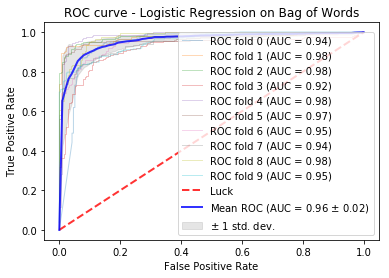

In [31]:
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc

n_samples, n_features = X.shape

random_state = random_seed

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
clf = clone(classifier)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - Logistic Regression on Bag of Words')
plt.legend(loc="lower right")
plt.show()